In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib
import h5py
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook as tqdm_loop
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../pytorch-cifar/models/")
from resnet_softplus import ResNet18

In [3]:
model = ResNet18()

In [4]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

11173962

In [5]:
model.load_state_dict(torch.load("models/RN18_standard.pth")["net"])

<All keys matched successfully>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.eval().to(device)

In [7]:
# Normalisation parameters fo CIFAR10
# means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
# stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

# normalize = transforms.Normalize(
#     mean=means,
#     std=stds,
# )

# train_transform = transforms.Compose([
#     # 4 pixels are padded on each side, 
#     transforms.Pad(4),
#     # a 32×32 crop is randomly sampled from the 
#     # padded image or its horizontal flip.
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomCrop(32),
#     transforms.ToTensor(),
#     normalize
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [8]:
cifar_test = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, 
                                          transform=transform_test)

Files already downloaded and verified


In [9]:
test_loader = torch.utils.data.DataLoader(
        cifar_test,
        batch_size=32,
        shuffle=False
    )

In [10]:
def accuracy(predicted_logits, reference):
    """Compute the ratio of correctly predicted labels"""
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

criterion = torch.nn.CrossEntropyLoss()

test_losses = []
test_accs = []
weights_for_avg = []
with torch.no_grad():
    for batch_x, batch_y in tqdm_loop(test_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        prediction = model(batch_x)
        loss = criterion(prediction, batch_y)
        acc = accuracy(prediction, batch_y)
        test_accs.append(acc)
        test_losses.append(loss)
        weights_for_avg.append(len(batch_x))
        del batch_x
        del batch_y
        torch.cuda.empty_cache()

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [11]:
np.average([i.cpu().item() for i in test_accs], weights=weights_for_avg)

0.9227

### explanation

In [12]:
from captum.attr import visualization as viz
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.loss_functions as lf
import mister_ed.utils.pytorch_utils as mister_ed_utils
from mister_ed.utils.pytorch_ssim import SSIM

In [13]:
dataiter = iter(test_loader)
image, label = next(dataiter)

In [14]:
idx = 10

In [15]:
img = image[idx].unsqueeze(dim=0).cuda()

In [16]:
img_label = label[idx]
img_label

tensor(0)

In [17]:
target_img = image[8].unsqueeze(0).cuda()
target_label = label[8]

org_expl = get_expl(model, img, "saliency", desired_index=img_label)
target_expl = get_expl(model, target_img, "saliency", desired_index=target_label, normalize=True).detach()
###############
delta = torch.zeros_like(img, requires_grad=True) #additive noised
nn.init.normal_(delta, mean=0.0, std=1e-2)
x_adv = img + delta
optimizer = torch.optim.Adam([delta], lr=0.001)

with torch.enable_grad():
    for i in range(20):
        optimizer.zero_grad()
        adv_expl = get_expl(model, x_adv, "saliency", desired_index=img_label, normalize=True)
        expl_loss = F.mse_loss(adv_expl, target_expl)
        delta_loss = torch.norm(delta)

        loss = (10**7)*expl_loss + 0.0*delta_loss
        print("total: {}, expl: {}, delta: {}".format(loss, expl_loss, delta_loss))
        loss.backward()
        optimizer.step()
        x_adv = img+delta

/home/ubuntu/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


total: 18.818117141723633, expl: 1.881811726889282e-06, delta: 0.5558162927627563
total: 17.13963508605957, expl: 1.7139634564955486e-06, delta: 0.5625285506248474
total: 15.884706497192383, expl: 1.5884706954238936e-06, delta: 0.5724449753761292
total: 14.974225044250488, expl: 1.4974225450714584e-06, delta: 0.5849351286888123
total: 14.184476852416992, expl: 1.4184477095113834e-06, delta: 0.5988566279411316
total: 13.53125286102295, expl: 1.3531252989196219e-06, delta: 0.6137310266494751
total: 13.019832611083984, expl: 1.3019832749705529e-06, delta: 0.6292703747749329
total: 12.5902738571167, expl: 1.2590273854584666e-06, delta: 0.6451314687728882
total: 12.193196296691895, expl: 1.2193196425869246e-06, delta: 0.6611953973770142
total: 11.846587181091309, expl: 1.1846586858155206e-06, delta: 0.67731773853302
total: 11.544012069702148, expl: 1.154401161329588e-06, delta: 0.6932313442230225
total: 11.289539337158203, expl: 1.1289539543213323e-06, delta: 0.7087528705596924
total: 11.04

In [18]:
delta.grad

tensor([[[[-0.0410, -0.0307, -0.0254,  ...,  0.0020, -0.0012,  0.0127],
          [ 0.0146,  0.0501,  0.0599,  ..., -0.0068,  0.0170, -0.0576],
          [-0.0165, -0.0908,  0.0468,  ...,  0.0149,  0.0259,  0.0404],
          ...,
          [ 0.0109, -0.0057,  0.0468,  ...,  0.0213, -0.0124, -0.0120],
          [ 0.0206, -0.0238,  0.0548,  ..., -0.0144,  0.0078, -0.0122],
          [-0.0142,  0.0192, -0.0455,  ...,  0.0004,  0.0083,  0.0064]],

         [[-0.0081, -0.0029,  0.0098,  ...,  0.0220,  0.0222,  0.0040],
          [ 0.0442,  0.0616,  0.1009,  ..., -0.0002,  0.0248, -0.0553],
          [-0.0150, -0.1021,  0.0329,  ..., -0.0109, -0.0236,  0.0422],
          ...,
          [ 0.0037, -0.0783,  0.0514,  ...,  0.0502,  0.0116, -0.0187],
          [ 0.0189, -0.0374,  0.0455,  ..., -0.0199,  0.0173, -0.0114],
          [-0.0105,  0.0343, -0.0420,  ..., -0.0155,  0.0036,  0.0044]],

         [[-0.0083, -0.0141, -0.0164,  ...,  0.0129,  0.0093,  0.0137],
          [ 0.0307,  0.0541,  

In [19]:
adv_expl = get_expl(model, x_adv, "saliency", desired_index=img_label)

(<Figure size 288x144 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe9cf511450>)

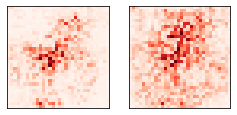

In [20]:
fig, ax = plt.subplots(1,2, figsize=(4,2))
viz.visualize_image_attr(np.transpose(org_expl.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[0]), use_pyplot=False)
viz.visualize_image_attr(np.transpose(adv_expl.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1]), use_pyplot=False)

### classes
0: airplane										
1: automobile										
2: bird										
3: cat										
4: deer										
5: dog										
6: frog										
7: horse										
8: ship										
9: truck

In [28]:
def cifar_tensor_to_image(tensor, data_mean=np.array([0.4914, 0.4822, 0.4465]), 
                               data_std=np.array([0.2023, 0.1994, 0.2010])):
    if len(tensor.shape) == 4:
        img = tensor.permute(0, 2, 3, 1)

    img = img.contiguous().squeeze().detach().cpu().numpy()

    img = img * data_std.reshape(1, 1, 3) + data_mean.reshape(1, 1, 3)
    return np.clip(img, 0, 1)

In [29]:
sigma = (torch.max(img) - torch.min(img)).item() * 0.1
sigma

0.3878741979598999

In [30]:
expl = get_expl(model, img.to(device), "saliency", desired_index=img_label.to(device),
               sigma=sigma)

/home/ubuntu/captum/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


(-0.5, 31.5, 31.5, -0.5)

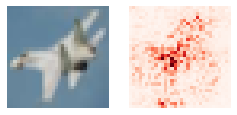

In [31]:
fig, ax = plt.subplots(1,2, figsize=(4,2))
ax[0].imshow(cifar_tensor_to_image(img))
viz.visualize_image_attr(np.transpose(expl.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
ax[0].axis('off')
ax[1].axis('off')

In [32]:
expl.requires_grad

True

In [24]:
torchvision.models.resnet18(pretrained=True)

<module 'torchvision.models' from '/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torchvision/models/__init__.py'>